In [ ]:
import torch
import random
import numpy as np

# Set a fixed random seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
class CustomDataset(Dataset):
    def __init__(self, npz_path):
        npz_data = np.load(npz_path)
        self.images = npz_data["images"] # (N, 3, 128, 128) in np.uint8
        self.labels = npz_data["labels"] # (N,) in np.int64
        assert self.images.shape[0] == self.labels.shape[0]
        print(f"{npz_path}: images shape {self.images.shape}, "
              f"labels shape {self.labels.shape}")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = torch.tensor(self.images[idx]) / 255 # convert to [0, 1] range
        label = torch.tensor(self.labels[idx])
        return image, label



In [ ]:
from torch.utils.data import random_split

full_dataset = CustomDataset("train.npz")

# 设置训练和验证比例
train_ratio = 0.8
train_size = int(train_ratio * len(full_dataset))
val_size = len(full_dataset) - train_size



# 使用 random_split 分割数据
train_dataset, val_dataset = random_split(
    full_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)  # 保证每次划分一致
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False, num_workers=2)

train.npz: images shape (18900, 3, 128, 128), labels shape (18900,)


In [ ]:
# sample data batch
images, labels = next(iter(train_loader))
print(f"images shape: {images.shape}")
print(f"labels shape: {labels.shape}")

images shape: torch.Size([32, 3, 128, 128])
labels shape: torch.Size([32])


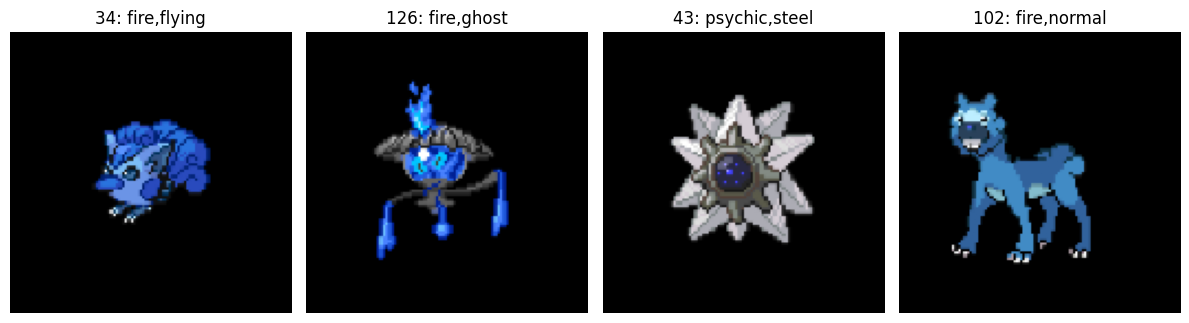

In [ ]:
import matplotlib.pyplot as plt

# load label text
with open('label2type.txt', 'r') as f:
    label2type = eval(f.read())

# plot samples
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for i, ax in enumerate(axes):
    label = labels[i].item()
    # (C, H, W) to (H, W, C) for plotting
    ax.imshow(images[i].numpy().transpose(1, 2, 0))
    ax.axis('off')
    ax.set_title(f"{label}: {label2type[label]}")
plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
class ResBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels),
            nn.LeakyReLU(0.2),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels)
        )
        self.activation = nn.LeakyReLU(0.2)

    def forward(self, x):
        return self.activation(x + self.block(x))

class Model(nn.Module):
    def __init__(self, input_channels=3, latent_channels=8, num_classes=170):
        super().__init__()
        self.latent_channels = latent_channels

        self.encoder = nn.Sequential(
            # H  H/2
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            ResBlock(64),

            # H/2  H/4
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            ResBlock(128),

            # H/4
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            ResBlock(256)
        )

        self.pre_quant_resblock = ResBlock(256)
        self.quant_conv = nn.Conv2d(256, latent_channels, kernel_size=1)

        self.post_quant_conv = nn.Conv2d(latent_channels, 256, kernel_size=1)
        self.post_quant_resblock = ResBlock(256)

        self.decoder = nn.Sequential(
            #  H/4
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            ResBlock(128),

            # H/4 H/2
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            ResBlock(64),

            # H/2  H
            nn.ConvTranspose2d(64, input_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )


        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(latent_channels, num_classes)
        )

    def encode(self,x):
        h = self.encoder(x)
        h = self.pre_quant_resblock(h)                # [B,512,H/8,W/8]
        z = self.quant_conv(h)    # [B, latent_channels, H/8, W/8]
        return z

    def decode(self, z):
        h = self.post_quant_conv(z)
        h = self.post_quant_resblock(h)      # [B,512,H/8,W/8]
        recon = self.decoder(h)            # [B,3,H,W]
        return recon

    def forward(self, x):
        z= self.encode(x)
        recon = self.decode(z)
        logits = self.classifier(z)
        return recon,logits, z


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import torchvision.models as models
import torch.nn.functional as F

# ----- 超参数 -----
initial_lr    = 1e-3
weight_decay  = 1e-5
factor        = 0.5
latent_dim    = 8  # 跟 Model(latent_channels=...) 保持一致
NUM_CLASSES   = 170
eps=1e-8

# ----- 损失函数 -----
mse_loss = nn.MSELoss(reduction='mean')
ce_loss  = nn.CrossEntropyLoss(reduction='mean')

# ----- 训练一个 epoch -----
def train_epoch(model, dataloader, optimizer, device, scheduler):
    model.train()
    total_loss, total_recon, total_pcp, total_cls = 0.0, 0.0, 0.0, 0.0
    correct = 0

    for images, labels in tqdm(dataloader, desc='Training'):
        images = images.to(device)
        labels = labels.to(device)

        # 前向传播
        recon, logits, _ = model(images)

        # 损失计算
        loss_recon = mse_loss(recon, images)
        loss_cls   = ce_loss(logits, labels)

        # 总损失 = 分类损失 + 重建损失 + 0.1 * 感知损失
        loss =  torch.log(loss_cls) + torch.log(loss_recon)

        # 计算准确率
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()

        # 反向传播与优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        # 累计统计
        bs = images.size(0)
        total_loss  += loss.item()       * bs
        total_recon += loss_recon.item() * bs
        total_cls   += loss_cls.item()   * bs

    n = len(dataloader.dataset)
    acc = correct / n
    return total_loss / n, total_recon / n,  total_cls / n, acc

# ----- 验证一个 epoch -----
def eval_epoch(model, dataloader, device):
    model.eval()
    total_loss, total_recon, total_pcp, total_cls = 0.0, 0.0, 0.0, 0.0
    correct = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Validating'):
            images = images.to(device)
            labels = labels.to(device)

            recon, logits, _ = model(images)

            loss_recon = mse_loss(recon, images)
            loss_cls   = ce_loss(logits, labels)

            loss = torch.log(loss_cls) + torch.log(loss_recon)

            bs = images.size(0)
            total_loss  += loss.item()       * bs
            total_recon += loss_recon.item() * bs
            total_cls   += loss_cls.item()   * bs
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()

    n = len(dataloader.dataset)
    acc = correct / n
    return total_loss / n, total_recon / n,  total_cls / n, acc

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model(input_channels=3, latent_channels=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=initial_lr, weight_decay=weight_decay)

# 新：使用自定义调度器
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=118250, eta_min=1e-6)


# ----- 训练循环 -----
num_epochs = 250
best_val_loss = float('inf')
wait=0
winner=0
for epoch in range(1, num_epochs+1):
    print(f"\nEpoch {epoch}/{num_epochs}")
    tr_loss, tr_recon,  tr_cls, tr_acc = train_epoch(model, train_loader, optimizer, device, scheduler)
    va_loss, va_recon,  va_cls, va_acc = eval_epoch(model, val_loader, device)

    print(f"Train Loss: {tr_loss:.4f} |{tr_recon*128*128*3:.4f} (R: {tr_recon:.8f}, C: {tr_cls:.4f})\n Acc:{tr_acc:.4f} Score:{tr_recon*128*128*3/tr_acc:.4f}")
    print(f" Val  Loss: {va_loss:.4f} |{va_recon*128*128*3 :.4f}(R: {va_recon:.8f}, C: {va_cls:.4f})\n Acc:{va_acc:.4f} Score:{va_recon*128*128*3/va_acc:.4f}")
    print(f" LR: {optimizer.param_groups[0]['lr']:.2e}")

    if va_loss < best_val_loss:
        wait=0
        best_val_loss = va_loss
        winner=epoch
        torch.save(model.state_dict(), "Adella002.pth")
        print(f">>>Epoch {epoch} Saved new best model")
    else:
        wait+=1
        print(f"wait={wait},winner={winner}")
        if wait>=100:
          break


Epoch 1/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.04it/s]


Train Loss: -3.5201 |427.5181 (R: 0.00869788, C: 5.1361)
 Acc:0.0095 Score:45203.3161
 Val  Loss: -3.9637 |186.1485(R: 0.00378720, C: 5.0397)
 Acc:0.0172 Score:10825.2496
 LR: 1.00e-03
>>>Epoch 1 Saved new best model

Epoch 2/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.77it/s]


Train Loss: -4.4178 |120.4853 (R: 0.00245128, C: 5.0312)
 Acc:0.0182 Score:6624.5026
 Val  Loss: -4.3896 |123.7026(R: 0.00251674, C: 4.9595)
 Acc:0.0180 Score:6876.4080
 LR: 1.00e-03
>>>Epoch 2 Saved new best model

Epoch 3/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 79.23it/s]


Train Loss: -4.7523 |86.6349 (R: 0.00176259, C: 4.9815)
 Acc:0.0201 Score:4308.9468
 Val  Loss: -3.9329 |196.1740(R: 0.00399117, C: 4.9359)
 Acc:0.0177 Score:11067.7294
 LR: 1.00e-03
wait=1,winner=2

Epoch 4/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 79.54it/s]


Train Loss: -4.9039 |74.9959 (R: 0.00152579, C: 4.9543)
 Acc:0.0208 Score:3599.8009
 Val  Loss: -5.0351 |65.3345(R: 0.00132923, C: 4.9343)
 Acc:0.0220 Score:2975.4740
 LR: 9.99e-04
>>>Epoch 4 Saved new best model

Epoch 5/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 77.08it/s]


Train Loss: -5.0671 |63.7599 (R: 0.00129720, C: 4.9294)
 Acc:0.0215 Score:2966.3080
 Val  Loss: -5.0407 |65.5107(R: 0.00133282, C: 4.8917)
 Acc:0.0278 Score:2358.3837
 LR: 9.99e-04
>>>Epoch 5 Saved new best model

Epoch 6/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 77.62it/s]


Train Loss: -5.1294 |60.3498 (R: 0.00122782, C: 4.9140)
 Acc:0.0233 Score:2584.9526
 Val  Loss: -4.6221 |99.4455(R: 0.00202322, C: 4.8886)
 Acc:0.0249 Score:3998.9774
 LR: 9.99e-04
wait=1,winner=5

Epoch 7/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.17it/s]


Train Loss: -5.2069 |56.0200 (R: 0.00113973, C: 4.8962)
 Acc:0.0230 Score:2433.9723
 Val  Loss: -4.9862 |68.1403(R: 0.00138632, C: 4.9665)
 Acc:0.0212 Score:3219.6271
 LR: 9.98e-04
wait=2,winner=5

Epoch 8/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 79.43it/s]


Train Loss: -5.2884 |51.6609 (R: 0.00105104, C: 4.8877)
 Acc:0.0257 Score:2013.1772
 Val  Loss: -4.7831 |85.2788(R: 0.00173500, C: 4.8590)
 Acc:0.0267 Score:3191.6228
 LR: 9.97e-04
wait=3,winner=5

Epoch 9/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.30it/s]


Train Loss: -5.3324 |49.5599 (R: 0.00100830, C: 4.8747)
 Acc:0.0271 Score:1827.6742
 Val  Loss: -5.4832 |42.5763(R: 0.00086622, C: 4.8484)
 Acc:0.0262 Score:1625.6411
 LR: 9.97e-04
>>>Epoch 9 Saved new best model

Epoch 10/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 79.32it/s]


Train Loss: -5.4003 |46.2807 (R: 0.00094158, C: 4.8658)
 Acc:0.0276 Score:1678.0918
 Val  Loss: -5.2037 |55.8784(R: 0.00113685, C: 4.8719)
 Acc:0.0249 Score:2247.0236
 LR: 9.96e-04
wait=1,winner=9

Epoch 11/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 79.39it/s]


Train Loss: -5.4280 |45.0947 (R: 0.00091745, C: 4.8620)
 Acc:0.0266 Score:1696.0978
 Val  Loss: -5.3165 |49.7387(R: 0.00101194, C: 4.8921)
 Acc:0.0257 Score:1938.2722
 LR: 9.95e-04
wait=2,winner=9

Epoch 12/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 79.07it/s]


Train Loss: -5.4975 |42.0229 (R: 0.00085496, C: 4.8515)
 Acc:0.0277 Score:1516.4333
 Val  Loss: -5.5020 |40.0073(R: 0.00081395, C: 5.0635)
 Acc:0.0159 Score:2520.4571
 LR: 9.94e-04
>>>Epoch 12 Saved new best model

Epoch 13/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 79.12it/s]


Train Loss: -5.5186 |41.2695 (R: 0.00083963, C: 4.8454)
 Acc:0.0276 Score:1496.3902
 Val  Loss: -5.1490 |59.5217(R: 0.00121097, C: 4.8286)
 Acc:0.0357 Score:1666.6083
 LR: 9.93e-04
wait=1,winner=12

Epoch 14/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 76.90it/s]


Train Loss: -5.5410 |40.3738 (R: 0.00082141, C: 4.8433)
 Acc:0.0270 Score:1496.2059
 Val  Loss: -5.3821 |47.2547(R: 0.00096140, C: 4.8242)
 Acc:0.0275 Score:1717.5275
 LR: 9.92e-04
wait=2,winner=12

Epoch 15/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 79.49it/s]


Train Loss: -5.5840 |38.6752 (R: 0.00078685, C: 4.8386)
 Acc:0.0278 Score:1388.9990
 Val  Loss: -5.2400 |54.4470(R: 0.00110773, C: 4.8243)
 Acc:0.0312 Score:1744.1485
 LR: 9.91e-04
wait=3,winner=12

Epoch 16/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 79.57it/s]


Train Loss: -5.5978 |38.2287 (R: 0.00077776, C: 4.8325)
 Acc:0.0300 Score:1275.9774
 Val  Loss: -4.8131 |81.8820(R: 0.00166589, C: 4.8918)
 Acc:0.0235 Score:3477.6862
 LR: 9.90e-04
wait=4,winner=12

Epoch 17/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.19it/s]


Train Loss: -5.6442 |36.5041 (R: 0.00074268, C: 4.8275)
 Acc:0.0274 Score:1333.1937
 Val  Loss: -5.5005 |40.0002(R: 0.00081381, C: 5.0688)
 Acc:0.0188 Score:2129.5864
 LR: 9.89e-04
wait=5,winner=12

Epoch 18/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.42it/s]


Train Loss: -5.6599 |36.0024 (R: 0.00073247, C: 4.8214)
 Acc:0.0298 Score:1206.9975
 Val  Loss: -5.1477 |56.0084(R: 0.00113949, C: 5.1402)
 Acc:0.0167 Score:3360.5036
 LR: 9.87e-04
wait=6,winner=12

Epoch 19/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.98it/s]


Train Loss: -5.6808 |35.2470 (R: 0.00071710, C: 4.8232)
 Acc:0.0290 Score:1216.7451
 Val  Loss: -5.6856 |35.0427(R: 0.00071295, C: 4.8161)
 Acc:0.0265 Score:1324.6159
 LR: 9.86e-04
>>>Epoch 19 Saved new best model

Epoch 20/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 77.34it/s]


Train Loss: -5.7081 |34.3297 (R: 0.00069844, C: 4.8176)
 Acc:0.0294 Score:1166.4392
 Val  Loss: -5.6326 |35.2616(R: 0.00071740, C: 5.0438)
 Acc:0.0164 Score:2149.8198
 LR: 9.84e-04
wait=1,winner=19

Epoch 21/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.86it/s]


Train Loss: -5.7164 |34.0156 (R: 0.00069205, C: 4.8201)
 Acc:0.0294 Score:1155.7674
 Val  Loss: -5.4892 |41.9042(R: 0.00085254, C: 4.8811)
 Acc:0.0257 Score:1632.9661
 LR: 9.83e-04
wait=2,winner=19

Epoch 22/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.37it/s]


Train Loss: -5.7406 |33.2207 (R: 0.00067588, C: 4.8180)
 Acc:0.0282 Score:1176.3403
 Val  Loss: -5.4662 |41.9196(R: 0.00085286, C: 5.0007)
 Acc:0.0190 Score:2200.7770
 LR: 9.81e-04
wait=3,winner=19

Epoch 23/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 77.44it/s]


Train Loss: -5.7564 |32.7349 (R: 0.00066599, C: 4.8113)
 Acc:0.0275 Score:1189.7865
 Val  Loss: -5.4319 |45.0469(R: 0.00091648, C: 4.8117)
 Acc:0.0310 Score:1455.3629
 LR: 9.79e-04
wait=4,winner=19

Epoch 24/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 79.10it/s]


Train Loss: -5.7843 |31.8558 (R: 0.00064811, C: 4.8078)
 Acc:0.0302 Score:1056.2713
 Val  Loss: -5.1344 |58.9456(R: 0.00119925, C: 4.9455)
 Acc:0.0198 Score:2970.8594
 LR: 9.77e-04
wait=5,winner=19

Epoch 25/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 77.86it/s]


Train Loss: -5.7719 |32.3052 (R: 0.00065725, C: 4.8046)
 Acc:0.0278 Score:1162.9870
 Val  Loss: -5.7723 |32.1778(R: 0.00065466, C: 4.8098)
 Acc:0.0275 Score:1169.5379
 LR: 9.76e-04
>>>Epoch 25 Saved new best model

Epoch 26/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.47it/s]


Train Loss: -5.8031 |31.2898 (R: 0.00063659, C: 4.8069)
 Acc:0.0293 Score:1067.9505
 Val  Loss: -5.5592 |39.6166(R: 0.00080600, C: 4.8225)
 Acc:0.0272 Score:1453.8907
 LR: 9.74e-04
wait=1,winner=25

Epoch 27/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 79.21it/s]


Train Loss: -5.8291 |30.4794 (R: 0.00062010, C: 4.8041)
 Acc:0.0295 Score:1033.2919
 Val  Loss: -5.7235 |30.3197(R: 0.00061685, C: 5.3614)
 Acc:0.0156 Score:1942.5134
 LR: 9.72e-04
wait=2,winner=25

Epoch 28/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 76.55it/s]


Train Loss: -5.8518 |29.8051 (R: 0.00060639, C: 4.8040)
 Acc:0.0292 Score:1019.5769
 Val  Loss: -5.5744 |35.6089(R: 0.00072446, C: 5.2898)
 Acc:0.0156 Score:2281.3836
 LR: 9.69e-04
wait=3,winner=25

Epoch 29/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.18it/s]


Train Loss: -5.8478 |29.9681 (R: 0.00060970, C: 4.7995)
 Acc:0.0293 Score:1022.8384
 Val  Loss: -5.6311 |37.1756(R: 0.00075634, C: 4.7844)
 Acc:0.0336 Score:1106.4870
 LR: 9.67e-04
wait=4,winner=25

Epoch 30/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.96it/s]


Train Loss: -5.8682 |29.3982 (R: 0.00059811, C: 4.7963)
 Acc:0.0299 Score:983.4072
 Val  Loss: -5.7860 |31.2703(R: 0.00063620, C: 4.8804)
 Acc:0.0233 Score:1343.2035
 LR: 9.65e-04
>>>Epoch 30 Saved new best model

Epoch 31/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.42it/s]


Train Loss: -5.8814 |29.0354 (R: 0.00059073, C: 4.7963)
 Acc:0.0290 Score:1000.0340
 Val  Loss: -5.8651 |29.4681(R: 0.00059953, C: 4.7884)
 Acc:0.0307 Score:960.2532
 LR: 9.63e-04
>>>Epoch 31 Saved new best model

Epoch 32/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.98it/s]


Train Loss: -5.9082 |28.2529 (R: 0.00057481, C: 4.7932)
 Acc:0.0302 Score:936.8072
 Val  Loss: -4.3111 |130.4683(R: 0.00265438, C: 5.0900)
 Acc:0.0249 Score:5246.4907
 LR: 9.60e-04
wait=1,winner=31

Epoch 33/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 76.87it/s]


Train Loss: -5.9131 |28.1226 (R: 0.00057216, C: 4.7919)
 Acc:0.0302 Score:930.4455
 Val  Loss: -5.8335 |29.6849(R: 0.00060394, C: 4.9082)
 Acc:0.0296 Score:1001.8639
 LR: 9.58e-04
wait=2,winner=31

Epoch 34/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.81it/s]


Train Loss: -5.9231 |27.8530 (R: 0.00056667, C: 4.7908)
 Acc:0.0321 Score:866.5373
 Val  Loss: -5.8819 |29.1793(R: 0.00059365, C: 4.7553)
 Acc:0.0315 Score:926.8719
 LR: 9.55e-04
>>>Epoch 34 Saved new best model

Epoch 35/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 79.27it/s]


Train Loss: -5.9326 |27.6397 (R: 0.00056233, C: 4.7863)
 Acc:0.0320 Score:863.4552
 Val  Loss: -5.9866 |26.1560(R: 0.00053214, C: 4.7840)
 Acc:0.0344 Score:760.5346
 LR: 9.52e-04
>>>Epoch 35 Saved new best model

Epoch 36/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.55it/s]


Train Loss: -5.9502 |27.1545 (R: 0.00055246, C: 4.7814)
 Acc:0.0296 Score:918.5159
 Val  Loss: -5.7942 |27.6444(R: 0.00056243, C: 5.4846)
 Acc:0.0095 Score:2902.6582
 LR: 9.50e-04
wait=1,winner=35

Epoch 37/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.57it/s]


Train Loss: -5.9503 |27.1466 (R: 0.00055230, C: 4.7845)
 Acc:0.0290 Score:934.9802
 Val  Loss: -5.1933 |43.0548(R: 0.00087595, C: 6.3766)
 Acc:0.0061 Score:7075.9686
 LR: 9.47e-04
wait=2,winner=35

Epoch 38/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.89it/s]


Train Loss: -5.9560 |27.0336 (R: 0.00055000, C: 4.7769)
 Acc:0.0305 Score:886.6545
 Val  Loss: -5.9760 |26.4531(R: 0.00053819, C: 4.7789)
 Acc:0.0307 Score:862.0052
 LR: 9.44e-04
wait=3,winner=35

Epoch 39/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.51it/s]


Train Loss: -5.9978 |25.9496 (R: 0.00052795, C: 4.7725)
 Acc:0.0328 Score:791.0429
 Val  Loss: -5.8989 |28.7330(R: 0.00058457, C: 4.7455)
 Acc:0.0288 Score:996.4296
 LR: 9.41e-04
wait=4,winner=35

Epoch 40/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.32it/s]


Train Loss: -5.9921 |26.0964 (R: 0.00053093, C: 4.7770)
 Acc:0.0321 Score:811.8865
 Val  Loss: -5.7661 |31.2170(R: 0.00063511, C: 4.9851)
 Acc:0.0235 Score:1325.8438
 LR: 9.38e-04
wait=5,winner=35

Epoch 41/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.36it/s]


Train Loss: -6.0050 |25.8011 (R: 0.00052492, C: 4.7659)
 Acc:0.0317 Score:812.7344
 Val  Loss: -5.9329 |26.3376(R: 0.00053584, C: 5.0107)
 Acc:0.0146 Score:1810.1122
 LR: 9.35e-04
wait=6,winner=35

Epoch 42/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.03it/s]


Train Loss: -6.0085 |25.7083 (R: 0.00052304, C: 4.7669)
 Acc:0.0331 Score:775.8677
 Val  Loss: -5.7341 |25.4289(R: 0.00051735, C: 6.3390)
 Acc:0.0085 Score:3003.7866
 LR: 9.32e-04
wait=7,winner=35

Epoch 43/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 77.63it/s]


Train Loss: -6.0072 |25.7342 (R: 0.00052356, C: 4.7697)
 Acc:0.0298 Score:862.7520
 Val  Loss: -5.8048 |26.4347(R: 0.00053782, C: 5.6763)
 Acc:0.0111 Score:2379.1221
 LR: 9.29e-04
wait=8,winner=35

Epoch 44/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 79.56it/s]


Train Loss: -6.0303 |25.1260 (R: 0.00051119, C: 4.7650)
 Acc:0.0317 Score:793.1218
 Val  Loss: -5.9216 |28.1486(R: 0.00057268, C: 4.7362)
 Acc:0.0354 Score:794.0417
 LR: 9.26e-04
wait=9,winner=35

Epoch 45/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 77.94it/s]


Train Loss: -6.0515 |24.6331 (R: 0.00050116, C: 4.7641)
 Acc:0.0315 Score:782.4636
 Val  Loss: -5.8626 |29.2438(R: 0.00059497, C: 4.8332)
 Acc:0.0265 Score:1105.4174
 LR: 9.22e-04
wait=10,winner=35

Epoch 46/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.13it/s]


Train Loss: -6.0443 |24.8121 (R: 0.00050480, C: 4.7644)
 Acc:0.0322 Score:770.3473
 Val  Loss: -6.0171 |24.2879(R: 0.00049414, C: 4.9964)
 Acc:0.0148 Score:1639.4342
 LR: 9.19e-04
>>>Epoch 46 Saved new best model

Epoch 47/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 77.65it/s]


Train Loss: -6.0603 |24.4316 (R: 0.00049706, C: 4.7607)
 Acc:0.0328 Score:744.7707
 Val  Loss: -5.8172 |29.3081(R: 0.00059627, C: 5.0469)
 Acc:0.0212 Score:1384.8058
 LR: 9.15e-04
wait=1,winner=46

Epoch 48/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.87it/s]


Train Loss: -6.0764 |24.0277 (R: 0.00048884, C: 4.7618)
 Acc:0.0308 Score:781.2873
 Val  Loss: -5.3412 |41.7287(R: 0.00084897, C: 5.6750)
 Acc:0.0188 Score:2221.6147
 LR: 9.12e-04
wait=2,winner=46

Epoch 49/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.07it/s]


Train Loss: -6.0847 |23.8867 (R: 0.00048598, C: 4.7564)
 Acc:0.0327 Score:731.1084
 Val  Loss: -5.6105 |30.0375(R: 0.00061111, C: 6.0538)
 Acc:0.0106 Score:2838.5420
 LR: 9.08e-04
wait=3,winner=46

Epoch 50/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.31it/s]


Train Loss: -6.0776 |24.0750 (R: 0.00048981, C: 4.7577)
 Acc:0.0313 Score:769.5844
 Val  Loss: -5.9317 |26.4391(R: 0.00053791, C: 4.9902)
 Acc:0.0180 Score:1469.7041
 LR: 9.05e-04
wait=4,winner=46

Epoch 51/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.64it/s]


Train Loss: -6.0962 |23.6297 (R: 0.00048075, C: 4.7588)
 Acc:0.0302 Score:783.5121
 Val  Loss: -5.6276 |29.7916(R: 0.00060611, C: 6.0005)
 Acc:0.0106 Score:2815.3099
 LR: 9.01e-04
wait=5,winner=46

Epoch 52/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 79.06it/s]


Train Loss: -6.1107 |23.2640 (R: 0.00047331, C: 4.7483)
 Acc:0.0316 Score:735.8817
 Val  Loss: -5.9879 |26.2722(R: 0.00053451, C: 4.7484)
 Acc:0.0323 Score:814.0087
 LR: 8.97e-04
wait=6,winner=46

Epoch 53/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 77.58it/s]


Train Loss: -6.1198 |23.0638 (R: 0.00046923, C: 4.7544)
 Acc:0.0311 Score:741.9659
 Val  Loss: -5.7440 |23.1616(R: 0.00047122, C: 6.8964)
 Acc:0.0066 Score:3502.0265
 LR: 8.93e-04
wait=7,winner=46

Epoch 54/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.25it/s]


Train Loss: -6.1132 |23.2154 (R: 0.00047232, C: 4.7492)
 Acc:0.0322 Score:720.7749
 Val  Loss: -5.6352 |36.5077(R: 0.00074275, C: 4.8440)
 Acc:0.0225 Score:1623.5207
 LR: 8.89e-04
wait=8,winner=46

Epoch 55/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.37it/s]


Train Loss: -6.1308 |22.8208 (R: 0.00046429, C: 4.7497)
 Acc:0.0336 Score:679.2328
 Val  Loss: -6.0538 |22.8747(R: 0.00046539, C: 5.1191)
 Acc:0.0220 Score:1041.7636
 LR: 8.85e-04
>>>Epoch 55 Saved new best model

Epoch 56/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 77.04it/s]


Train Loss: -6.1394 |22.6374 (R: 0.00046056, C: 4.7469)
 Acc:0.0332 Score:681.8281
 Val  Loss: -6.0659 |23.1983(R: 0.00047197, C: 4.9833)
 Acc:0.0251 Score:923.0483
 LR: 8.81e-04
>>>Epoch 56 Saved new best model

Epoch 57/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 79.07it/s]


Train Loss: -6.1463 |22.4724 (R: 0.00045720, C: 4.7442)
 Acc:0.0326 Score:689.2135
 Val  Loss: -6.0694 |24.1505(R: 0.00049134, C: 4.7653)
 Acc:0.0288 Score:837.5132
 LR: 8.77e-04
>>>Epoch 57 Saved new best model

Epoch 58/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 77.83it/s]


Train Loss: -6.1485 |22.3996 (R: 0.00045572, C: 4.7499)
 Acc:0.0312 Score:717.5470
 Val  Loss: -5.9631 |23.1355(R: 0.00047069, C: 5.5392)
 Acc:0.0143 Score:1619.4860
 LR: 8.73e-04
wait=1,winner=57

Epoch 59/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 77.24it/s]


Train Loss: -6.1611 |22.1402 (R: 0.00045044, C: 4.7444)
 Acc:0.0323 Score:684.5810
 Val  Loss: -5.8466 |23.4523(R: 0.00047714, C: 6.1407)
 Acc:0.0101 Score:2332.8824
 LR: 8.69e-04
wait=2,winner=57

Epoch 60/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.54it/s]


Train Loss: -6.1696 |21.9724 (R: 0.00044703, C: 4.7386)
 Acc:0.0312 Score:705.3570
 Val  Loss: -5.9797 |25.3104(R: 0.00051494, C: 4.9744)
 Acc:0.0225 Score:1125.5679
 LR: 8.65e-04
wait=3,winner=57

Epoch 61/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 79.11it/s]


Train Loss: -6.1774 |21.7719 (R: 0.00044295, C: 4.7464)
 Acc:0.0341 Score:637.9674
 Val  Loss: -5.5343 |29.8876(R: 0.00060806, C: 6.5695)
 Acc:0.0103 Score:2896.7977
 LR: 8.60e-04
wait=4,winner=57

Epoch 62/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 79.06it/s]


Train Loss: -6.1788 |21.7710 (R: 0.00044293, C: 4.7454)
 Acc:0.0329 Score:660.9987
 Val  Loss: -6.0202 |25.4215(R: 0.00051720, C: 4.7509)
 Acc:0.0328 Score:774.9467
 LR: 8.56e-04
wait=5,winner=57

Epoch 63/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 79.29it/s]


Train Loss: -6.1986 |21.3988 (R: 0.00043536, C: 4.7361)
 Acc:0.0327 Score:653.6358
 Val  Loss: -5.9222 |22.6793(R: 0.00046141, C: 5.8843)
 Acc:0.0106 Score:2143.1932
 LR: 8.51e-04
wait=6,winner=57

Epoch 64/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 76.40it/s]


Train Loss: -6.2017 |21.3157 (R: 0.00043367, C: 4.7349)
 Acc:0.0304 Score:702.1640
 Val  Loss: -6.0110 |21.7634(R: 0.00044278, C: 5.6139)
 Acc:0.0108 Score:2006.4790
 LR: 8.47e-04
wait=7,winner=57

Epoch 65/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.47it/s]


Train Loss: -6.2035 |21.2634 (R: 0.00043261, C: 4.7434)
 Acc:0.0311 Score:684.0491
 Val  Loss: -5.9967 |23.6536(R: 0.00048123, C: 5.2312)
 Acc:0.0153 Score:1541.5590
 LR: 8.42e-04
wait=8,winner=57

Epoch 66/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.22it/s]


Train Loss: -6.2201 |20.9260 (R: 0.00042574, C: 4.7350)
 Acc:0.0316 Score:661.9272
 Val  Loss: -5.9605 |24.1730(R: 0.00049180, C: 5.3080)
 Acc:0.0143 Score:1692.1106
 LR: 8.38e-04
wait=9,winner=57

Epoch 67/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.42it/s]


Train Loss: -6.2198 |20.9012 (R: 0.00042524, C: 4.7376)
 Acc:0.0330 Score:633.3199
 Val  Loss: -6.0924 |23.0366(R: 0.00046868, C: 4.8836)
 Acc:0.0291 Score:791.6199
 LR: 8.33e-04
>>>Epoch 67 Saved new best model

Epoch 68/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 79.52it/s]


Train Loss: -6.2289 |20.7633 (R: 0.00042243, C: 4.7327)
 Acc:0.0337 Score:615.5710
 Val  Loss: -6.1817 |21.0970(R: 0.00042922, C: 4.8820)
 Acc:0.0220 Score:960.8020
 LR: 8.28e-04
>>>Epoch 68 Saved new best model

Epoch 69/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 79.22it/s]


Train Loss: -6.2294 |20.7658 (R: 0.00042248, C: 4.7351)
 Acc:0.0333 Score:624.2122
 Val  Loss: -6.2193 |21.0432(R: 0.00042812, C: 4.7153)
 Acc:0.0325 Score:646.6926
 LR: 8.24e-04
>>>Epoch 69 Saved new best model

Epoch 70/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.55it/s]


Train Loss: -6.2325 |20.6711 (R: 0.00042055, C: 4.7364)
 Acc:0.0311 Score:664.9921
 Val  Loss: -6.1226 |22.8510(R: 0.00046490, C: 4.7813)
 Acc:0.0299 Score:764.3955
 LR: 8.19e-04
wait=1,winner=69

Epoch 71/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.53it/s]


Train Loss: -6.2410 |20.5500 (R: 0.00041809, C: 4.7279)
 Acc:0.0322 Score:638.0203
 Val  Loss: -6.1062 |22.3029(R: 0.00045375, C: 4.9767)
 Acc:0.0249 Score:896.8623
 LR: 8.14e-04
wait=2,winner=69

Epoch 72/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 79.35it/s]


Train Loss: -6.2431 |20.4821 (R: 0.00041671, C: 4.7298)
 Acc:0.0327 Score:626.9023
 Val  Loss: -5.8386 |25.6525(R: 0.00052190, C: 5.6463)
 Acc:0.0146 Score:1763.0258
 LR: 8.09e-04
wait=3,winner=69

Epoch 73/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.93it/s]


Train Loss: -6.2566 |20.2123 (R: 0.00041122, C: 4.7322)
 Acc:0.0342 Score:591.1224
 Val  Loss: -6.2628 |20.1746(R: 0.00041045, C: 4.7127)
 Acc:0.0347 Score:582.1374
 LR: 8.04e-04
>>>Epoch 73 Saved new best model

Epoch 74/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.30it/s]


Train Loss: -6.2574 |20.2144 (R: 0.00041126, C: 4.7288)
 Acc:0.0343 Score:588.9041
 Val  Loss: -5.9822 |23.1415(R: 0.00047081, C: 5.4243)
 Acc:0.0146 Score:1590.4489
 LR: 7.99e-04
wait=1,winner=73

Epoch 75/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.70it/s]


Train Loss: -6.2721 |19.8757 (R: 0.00040437, C: 4.7278)
 Acc:0.0337 Score:590.4137
 Val  Loss: -6.0243 |24.4924(R: 0.00049830, C: 4.9104)
 Acc:0.0228 Score:1076.5258
 LR: 7.94e-04
wait=2,winner=73

Epoch 76/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 77.97it/s]


Train Loss: -6.2777 |19.7920 (R: 0.00040267, C: 4.7238)
 Acc:0.0326 Score:607.0090
 Val  Loss: -6.2248 |20.6954(R: 0.00042105, C: 4.7667)
 Acc:0.0333 Score:620.8630
 LR: 7.89e-04
wait=3,winner=73

Epoch 77/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.50it/s]


Train Loss: -6.2920 |19.5392 (R: 0.00039753, C: 4.7211)
 Acc:0.0327 Score:598.0407
 Val  Loss: -6.1527 |21.0896(R: 0.00042907, C: 5.0265)
 Acc:0.0254 Score:830.4024
 LR: 7.84e-04
wait=4,winner=73

Epoch 78/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.64it/s]


Train Loss: -6.2789 |19.7953 (R: 0.00040274, C: 4.7257)
 Acc:0.0335 Score:590.3456
 Val  Loss: -6.0241 |22.5346(R: 0.00045847, C: 5.3487)
 Acc:0.0183 Score:1234.5063
 LR: 7.79e-04
wait=5,winner=73

Epoch 79/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.99it/s]


Train Loss: -6.3002 |19.3967 (R: 0.00039463, C: 4.7165)
 Acc:0.0345 Score:562.9126
 Val  Loss: -6.2174 |20.7599(R: 0.00042236, C: 4.7869)
 Acc:0.0349 Score:594.4888
 LR: 7.73e-04
wait=6,winner=73

Epoch 80/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 79.03it/s]


Train Loss: -6.3113 |19.1989 (R: 0.00039060, C: 4.7145)
 Acc:0.0321 Score:597.3003
 Val  Loss: -4.9468 |70.3564(R: 0.00143141, C: 5.0345)
 Acc:0.0262 Score:2686.3365
 LR: 7.68e-04
wait=7,winner=73

Epoch 81/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.33it/s]


Train Loss: -6.3160 |19.1315 (R: 0.00038923, C: 4.7077)
 Acc:0.0338 Score:566.0816
 Val  Loss: -5.8449 |20.4175(R: 0.00041540, C: 7.0739)
 Acc:0.0093 Score:2205.0903
 LR: 7.63e-04
wait=8,winner=73

Epoch 82/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.42it/s]


Train Loss: -6.3126 |19.1549 (R: 0.00038971, C: 4.7161)
 Acc:0.0347 Score:551.6604
 Val  Loss: -6.2849 |19.6003(R: 0.00039877, C: 4.7420)
 Acc:0.0357 Score:548.8080
 LR: 7.57e-04
>>>Epoch 82 Saved new best model

Epoch 83/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.04it/s]


Train Loss: -6.3217 |18.9809 (R: 0.00038617, C: 4.7185)
 Acc:0.0337 Score:563.8340
 Val  Loss: -6.2475 |20.2308(R: 0.00041160, C: 4.7669)
 Acc:0.0294 Score:688.9401
 LR: 7.52e-04
wait=1,winner=82

Epoch 84/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.54it/s]


Train Loss: -6.3210 |18.9950 (R: 0.00038646, C: 4.7125)
 Acc:0.0345 Score:550.2012
 Val  Loss: -6.2596 |19.5201(R: 0.00039714, C: 4.8839)
 Acc:0.0267 Score:730.5555
 LR: 7.47e-04
wait=2,winner=82

Epoch 85/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.87it/s]


Train Loss: -6.3279 |18.8459 (R: 0.00038342, C: 4.7153)
 Acc:0.0342 Score:551.1600
 Val  Loss: -6.1497 |20.6092(R: 0.00041929, C: 5.1585)
 Acc:0.0156 Score:1320.3839
 LR: 7.41e-04
wait=3,winner=82

Epoch 86/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.38it/s]


Train Loss: -6.3345 |18.7640 (R: 0.00038176, C: 4.7079)
 Acc:0.0325 Score:576.6507
 Val  Loss: -6.1225 |22.8195(R: 0.00046426, C: 4.7807)
 Acc:0.0339 Score:673.8878
 LR: 7.36e-04
wait=4,winner=82

Epoch 87/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.79it/s]


Train Loss: -6.3381 |18.6959 (R: 0.00038037, C: 4.7077)
 Acc:0.0353 Score:530.3593
 Val  Loss: -6.0719 |21.5765(R: 0.00043897, C: 5.3244)
 Acc:0.0212 Score:1019.4876
 LR: 7.30e-04
wait=5,winner=82

Epoch 88/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 79.11it/s]


Train Loss: -6.3451 |18.5603 (R: 0.00037761, C: 4.7089)
 Acc:0.0333 Score:556.8092
 Val  Loss: -6.3376 |18.5869(R: 0.00037815, C: 4.7479)
 Acc:0.0294 Score:632.9593
 LR: 7.24e-04
>>>Epoch 88 Saved new best model

Epoch 89/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 77.52it/s]


Train Loss: -6.3386 |18.7172 (R: 0.00038080, C: 4.7089)
 Acc:0.0332 Score:563.7529
 Val  Loss: -6.1676 |21.3074(R: 0.00043350, C: 4.9066)
 Acc:0.0251 Score:847.8117
 LR: 7.19e-04
wait=1,winner=88

Epoch 90/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.95it/s]


Train Loss: -6.3572 |18.4056 (R: 0.00037446, C: 4.6986)
 Acc:0.0347 Score:531.0927
 Val  Loss: -6.1106 |21.6593(R: 0.00044066, C: 5.0989)
 Acc:0.0212 Score:1023.4014
 LR: 7.13e-04
wait=2,winner=88

Epoch 91/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.98it/s]


Train Loss: -6.3557 |18.3966 (R: 0.00037428, C: 4.6995)
 Acc:0.0347 Score:529.8214
 Val  Loss: -6.1717 |21.9206(R: 0.00044598, C: 4.7395)
 Acc:0.0354 Score:618.3572
 LR: 7.07e-04
wait=3,winner=88

Epoch 92/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.65it/s]


Train Loss: -6.3670 |18.2316 (R: 0.00037092, C: 4.6961)
 Acc:0.0367 Score:496.6869
 Val  Loss: -5.8867 |21.1377(R: 0.00043005, C: 6.5461)
 Acc:0.0087 Score:2421.2317
 LR: 7.02e-04
wait=4,winner=88

Epoch 93/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.26it/s]


Train Loss: -6.3749 |18.0571 (R: 0.00036737, C: 4.6981)
 Acc:0.0340 Score:531.1751
 Val  Loss: -6.1669 |19.8636(R: 0.00040413, C: 5.2620)
 Acc:0.0146 Score:1365.1717
 LR: 6.96e-04
wait=5,winner=88

Epoch 94/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.46it/s]


Train Loss: -6.3756 |18.0575 (R: 0.00036738, C: 4.6932)
 Acc:0.0357 Score:505.6106
 Val  Loss: -6.1693 |19.7272(R: 0.00040135, C: 5.2859)
 Acc:0.0185 Score:1065.2673
 LR: 6.90e-04
wait=6,winner=88

Epoch 95/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.09it/s]


Train Loss: -6.3811 |17.9790 (R: 0.00036578, C: 4.6941)
 Acc:0.0344 Score:522.7754
 Val  Loss: -6.1971 |20.8931(R: 0.00042507, C: 4.8488)
 Acc:0.0254 Score:822.6674
 LR: 6.84e-04
wait=7,winner=88

Epoch 96/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.66it/s]


Train Loss: -6.3927 |17.7433 (R: 0.00036099, C: 4.6924)
 Acc:0.0338 Score:525.0066
 Val  Loss: -6.0536 |20.3891(R: 0.00041482, C: 5.7428)
 Acc:0.0206 Score:988.0863
 LR: 6.79e-04
wait=8,winner=88

Epoch 97/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 77.39it/s]


Train Loss: -6.3985 |17.6592 (R: 0.00035928, C: 4.6962)
 Acc:0.0372 Score:474.2585
 Val  Loss: -6.3023 |18.9369(R: 0.00038527, C: 4.8233)
 Acc:0.0312 Score:606.6226
 LR: 6.73e-04
wait=9,winner=88

Epoch 98/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.68it/s]


Train Loss: -6.3919 |17.7996 (R: 0.00036213, C: 4.6945)
 Acc:0.0363 Score:490.2196
 Val  Loss: -6.2533 |19.7910(R: 0.00040265, C: 4.8437)
 Acc:0.0230 Score:859.8838
 LR: 6.67e-04
wait=10,winner=88

Epoch 99/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.49it/s]


Train Loss: -6.4001 |17.6545 (R: 0.00035918, C: 4.6930)
 Acc:0.0338 Score:522.3798
 Val  Loss: -6.1480 |21.3367(R: 0.00043410, C: 4.9848)
 Acc:0.0233 Score:916.5080
 LR: 6.61e-04
wait=11,winner=88

Epoch 100/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 74.86it/s]


Train Loss: -6.4149 |17.4290 (R: 0.00035459, C: 4.6850)
 Acc:0.0356 Score:488.9168
 Val  Loss: -6.3262 |18.5570(R: 0.00037754, C: 4.8086)
 Acc:0.0286 Score:649.4939
 LR: 6.55e-04
wait=12,winner=88

Epoch 101/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 79.13it/s]


Train Loss: -6.4110 |17.4696 (R: 0.00035542, C: 4.6830)
 Acc:0.0381 Score:458.5782
 Val  Loss: -6.0398 |17.6890(R: 0.00035988, C: 6.7318)
 Acc:0.0130 Score:1364.5815
 LR: 6.49e-04
wait=13,winner=88

Epoch 102/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.42it/s]


Train Loss: -6.4242 |17.2223 (R: 0.00035039, C: 4.6907)
 Acc:0.0348 Score:495.0582
 Val  Loss: -6.2316 |18.9628(R: 0.00038580, C: 5.1705)
 Acc:0.0214 Score:884.9313
 LR: 6.43e-04
wait=14,winner=88

Epoch 103/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.11it/s]


Train Loss: -6.4151 |17.4335 (R: 0.00035469, C: 4.6803)
 Acc:0.0377 Score:462.4473
 Val  Loss: -6.2965 |19.4953(R: 0.00039663, C: 4.7121)
 Acc:0.0344 Score:566.8643
 LR: 6.37e-04
wait=15,winner=88

Epoch 104/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 76.85it/s]


Train Loss: -6.4338 |17.1198 (R: 0.00034830, C: 4.6813)
 Acc:0.0347 Score:493.0497
 Val  Loss: -6.2041 |20.5832(R: 0.00041877, C: 4.8896)
 Acc:0.0272 Score:755.3836
 LR: 6.31e-04
wait=16,winner=88

Epoch 105/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 77.65it/s]


Train Loss: -6.4308 |17.1861 (R: 0.00034965, C: 4.6711)
 Acc:0.0366 Score:469.8993
 Val  Loss: -6.3148 |19.1983(R: 0.00039059, C: 4.6968)
 Acc:0.0381 Score:503.9541
 LR: 6.25e-04
wait=17,winner=88

Epoch 106/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.80it/s]


Train Loss: -6.4412 |17.0106 (R: 0.00034608, C: 4.6719)
 Acc:0.0356 Score:478.0662
 Val  Loss: -6.1286 |17.8578(R: 0.00036332, C: 6.0957)
 Acc:0.0143 Score:1250.0450
 LR: 6.19e-04
wait=18,winner=88

Epoch 107/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.95it/s]


Train Loss: -6.4377 |17.0686 (R: 0.00034726, C: 4.6776)
 Acc:0.0356 Score:478.8079
 Val  Loss: -6.2069 |18.4877(R: 0.00037613, C: 5.4401)
 Acc:0.0167 Score:1109.2610
 LR: 6.13e-04
wait=19,winner=88

Epoch 108/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 77.98it/s]


Train Loss: -6.4445 |16.9311 (R: 0.00034446, C: 4.6782)
 Acc:0.0348 Score:486.6882
 Val  Loss: -6.2711 |18.2893(R: 0.00037210, C: 5.1547)
 Acc:0.0235 Score:776.7829
 LR: 6.06e-04
wait=20,winner=88

Epoch 109/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 77.51it/s]


Train Loss: -6.4546 |16.8104 (R: 0.00034201, C: 4.6652)
 Acc:0.0356 Score:472.4420
 Val  Loss: -5.6387 |18.1156(R: 0.00036856, C: 9.8272)
 Acc:0.0135 Score:1342.6819
 LR: 6.00e-04
wait=21,winner=88

Epoch 110/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 77.24it/s]


Train Loss: -6.4516 |16.8236 (R: 0.00034228, C: 4.6739)
 Acc:0.0362 Score:465.0340
 Val  Loss: -6.0575 |18.8815(R: 0.00038415, C: 6.1789)
 Acc:0.0156 Score:1209.6993
 LR: 5.94e-04
wait=22,winner=88

Epoch 111/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 79.02it/s]


Train Loss: -6.4548 |16.7996 (R: 0.00034179, C: 4.6685)
 Acc:0.0365 Score:460.1624
 Val  Loss: -5.9153 |17.2763(R: 0.00035149, C: 7.8138)
 Acc:0.0108 Score:1592.7884
 LR: 5.88e-04
wait=23,winner=88

Epoch 112/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 75.68it/s]


Train Loss: -6.4746 |16.4787 (R: 0.00033526, C: 4.6649)
 Acc:0.0359 Score:458.8541
 Val  Loss: -6.0073 |18.2827(R: 0.00037196, C: 6.7174)
 Acc:0.0103 Score:1772.0136
 LR: 5.82e-04
wait=24,winner=88

Epoch 113/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 79.00it/s]


Train Loss: -6.4671 |16.5720 (R: 0.00033716, C: 4.6708)
 Acc:0.0375 Score:441.9204
 Val  Loss: -6.2695 |18.8665(R: 0.00038384, C: 5.0011)
 Acc:0.0262 Score:720.3577
 LR: 5.76e-04
wait=25,winner=88

Epoch 114/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.91it/s]


Train Loss: -6.4770 |16.4272 (R: 0.00033421, C: 4.6660)
 Acc:0.0347 Score:474.0075
 Val  Loss: -6.2260 |17.0970(R: 0.00034784, C: 5.7784)
 Acc:0.0151 Score:1133.8013
 LR: 5.69e-04
wait=26,winner=88

Epoch 115/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.63it/s]


Train Loss: -6.4774 |16.4288 (R: 0.00033424, C: 4.6629)
 Acc:0.0368 Score:446.7678
 Val  Loss: -6.4357 |17.1213(R: 0.00034833, C: 4.6739)
 Acc:0.0405 Score:422.9976
 LR: 5.63e-04
>>>Epoch 115 Saved new best model

Epoch 116/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 77.82it/s]


Train Loss: -6.4716 |16.5296 (R: 0.00033630, C: 4.6622)
 Acc:0.0384 Score:430.9108
 Val  Loss: -6.3968 |17.3016(R: 0.00035200, C: 4.8090)
 Acc:0.0370 Score:467.1419
 LR: 5.57e-04
wait=1,winner=115

Epoch 117/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.16it/s]


Train Loss: -6.4928 |16.1882 (R: 0.00032935, C: 4.6598)
 Acc:0.0368 Score:440.2267
 Val  Loss: -6.3826 |18.1316(R: 0.00036889, C: 4.6502)
 Acc:0.0415 Score:436.5446
 LR: 5.51e-04
wait=2,winner=115

Epoch 118/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.09it/s]


Train Loss: -6.4913 |16.2117 (R: 0.00032983, C: 4.6600)
 Acc:0.0371 Score:436.9349
 Val  Loss: -4.6799 |89.5152(R: 0.00182119, C: 5.1569)
 Acc:0.0257 Score:3488.3253
 LR: 5.44e-04
wait=3,winner=115

Epoch 119/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 77.28it/s]


Train Loss: -6.5042 |16.0238 (R: 0.00032601, C: 4.6570)
 Acc:0.0377 Score:425.0525
 Val  Loss: -6.2098 |17.9647(R: 0.00036549, C: 5.5815)
 Acc:0.0193 Score:930.2289
 LR: 5.38e-04
wait=4,winner=115

Epoch 120/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.22it/s]


Train Loss: -6.4966 |16.1351 (R: 0.00032827, C: 4.6556)
 Acc:0.0374 Score:431.7916
 Val  Loss: -6.3260 |18.7762(R: 0.00038200, C: 4.7500)
 Acc:0.0325 Score:577.0258
 LR: 5.32e-04
wait=5,winner=115

Epoch 121/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.07it/s]


Train Loss: -6.4938 |16.2132 (R: 0.00032986, C: 4.6484)
 Acc:0.0378 Score:428.5731
 Val  Loss: -6.3705 |17.5661(R: 0.00035738, C: 4.8604)
 Acc:0.0262 Score:670.7060
 LR: 5.26e-04
wait=6,winner=115

Epoch 122/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 77.84it/s]


Train Loss: -6.5080 |16.0178 (R: 0.00032588, C: 4.6455)
 Acc:0.0375 Score:427.1421
 Val  Loss: -5.2743 |17.1500(R: 0.00034892, C: 14.9662)
 Acc:0.0056 Score:3086.9959
 LR: 5.19e-04
wait=7,winner=115

Epoch 123/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.58it/s]


Train Loss: -6.5123 |15.9372 (R: 0.00032424, C: 4.6481)
 Acc:0.0403 Score:395.0341
 Val  Loss: -6.4306 |16.8846(R: 0.00034352, C: 4.7641)
 Acc:0.0267 Score:631.9180
 LR: 5.13e-04
wait=8,winner=115

Epoch 124/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 76.16it/s]


Train Loss: -6.5171 |15.8293 (R: 0.00032205, C: 4.6525)
 Acc:0.0351 Score:451.5830
 Val  Loss: -5.1978 |18.8948(R: 0.00038441, C: 14.6322)
 Acc:0.0058 Score:3246.4641
 LR: 5.07e-04
wait=9,winner=115

Epoch 125/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 75.56it/s]


Train Loss: -6.5210 |15.7648 (R: 0.00032074, C: 4.6468)
 Acc:0.0376 Score:419.6541
 Val  Loss: -6.3586 |18.0898(R: 0.00036804, C: 4.7735)
 Acc:0.0339 Score:534.2132
 LR: 5.00e-04
wait=10,winner=115

Epoch 126/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.68it/s]


Train Loss: -6.5299 |15.6537 (R: 0.00031848, C: 4.6448)
 Acc:0.0385 Score:406.6741
 Val  Loss: -6.3932 |17.2443(R: 0.00035084, C: 4.8412)
 Acc:0.0310 Score:557.1226
 LR: 4.94e-04
wait=11,winner=115

Epoch 127/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.51it/s]


Train Loss: -6.5297 |15.7041 (R: 0.00031950, C: 4.6335)
 Acc:0.0372 Score:422.5025
 Val  Loss: -6.2493 |17.1481(R: 0.00034888, C: 5.6279)
 Acc:0.0201 Score:852.8935
 LR: 4.88e-04
wait=12,winner=115

Epoch 128/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.78it/s]


Train Loss: -6.5411 |15.4999 (R: 0.00031535, C: 4.6352)
 Acc:0.0405 Score:382.3150
 Val  Loss: -6.3374 |17.5995(R: 0.00035806, C: 5.0143)
 Acc:0.0265 Score:665.2616
 LR: 4.82e-04
wait=13,winner=115

Epoch 129/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 77.75it/s]


Train Loss: -6.5284 |15.7231 (R: 0.00031989, C: 4.6372)
 Acc:0.0357 Score:440.2458
 Val  Loss: -6.2825 |17.5905(R: 0.00035788, C: 5.3007)
 Acc:0.0206 Score:852.4603
 LR: 4.75e-04
wait=14,winner=115

Epoch 130/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 77.08it/s]


Train Loss: -6.5376 |15.5893 (R: 0.00031717, C: 4.6283)
 Acc:0.0376 Score:414.2541
 Val  Loss: -6.2180 |20.0959(R: 0.00040885, C: 4.9371)
 Acc:0.0288 Score:696.9032
 LR: 4.69e-04
wait=15,winner=115

Epoch 131/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 75.21it/s]


Train Loss: -6.5502 |15.3794 (R: 0.00031290, C: 4.6302)
 Acc:0.0399 Score:384.9950
 Val  Loss: -6.4175 |16.5591(R: 0.00033690, C: 4.9246)
 Acc:0.0251 Score:658.8766
 LR: 4.63e-04
wait=16,winner=115

Epoch 132/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 79.25it/s]


Train Loss: -6.5499 |15.3756 (R: 0.00031282, C: 4.6293)
 Acc:0.0407 Score:377.4011
 Val  Loss: -6.2642 |18.1176(R: 0.00036860, C: 5.2381)
 Acc:0.0238 Score:760.9391
 LR: 4.57e-04
wait=17,winner=115

Epoch 133/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 77.51it/s]


Train Loss: -6.5512 |15.3750 (R: 0.00031280, C: 4.6247)
 Acc:0.0399 Score:385.5218
 Val  Loss: -6.4020 |17.3005(R: 0.00035198, C: 4.7815)
 Acc:0.0312 Score:554.2028
 LR: 4.50e-04
wait=18,winner=115

Epoch 134/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 75.81it/s]


Train Loss: -6.5599 |15.2640 (R: 0.00031055, C: 4.6251)
 Acc:0.0401 Score:380.8442
 Val  Loss: -6.2818 |17.1530(R: 0.00034898, C: 5.4405)
 Acc:0.0183 Score:939.6866
 LR: 4.44e-04
wait=19,winner=115

Epoch 135/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.14it/s]


Train Loss: -6.5601 |15.2481 (R: 0.00031022, C: 4.6225)
 Acc:0.0411 Score:370.6608
 Val  Loss: -6.3438 |16.7077(R: 0.00033992, C: 5.2519)
 Acc:0.0235 Score:709.6089
 LR: 4.38e-04
wait=20,winner=115

Epoch 136/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.55it/s]


Train Loss: -6.5664 |15.2345 (R: 0.00030995, C: 4.6092)
 Acc:0.0392 Score:389.0963
 Val  Loss: -6.3743 |16.8200(R: 0.00034220, C: 5.0610)
 Acc:0.0259 Score:648.7727
 LR: 4.32e-04
wait=21,winner=115

Epoch 137/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.70it/s]


Train Loss: -6.5694 |15.1229 (R: 0.00030768, C: 4.6152)
 Acc:0.0416 Score:363.5263
 Val  Loss: -3.7756 |204.2487(R: 0.00415545, C: 5.6355)
 Acc:0.0220 Score:9301.9294
 LR: 4.25e-04
wait=22,winner=115

Epoch 138/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 77.11it/s]


Train Loss: -6.5757 |15.0393 (R: 0.00030598, C: 4.6199)
 Acc:0.0408 Score:368.5484
 Val  Loss: -6.4427 |16.7091(R: 0.00033995, C: 4.7551)
 Acc:0.0331 Score:505.2819
 LR: 4.19e-04
>>>Epoch 138 Saved new best model

Epoch 139/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.57it/s]


Train Loss: -6.5844 |14.9341 (R: 0.00030383, C: 4.6154)
 Acc:0.0407 Score:367.1599
 Val  Loss: -6.4244 |16.9370(R: 0.00034458, C: 4.7779)
 Acc:0.0347 Score:488.7171
 LR: 4.13e-04
wait=1,winner=138

Epoch 140/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.28it/s]


Train Loss: -6.5771 |15.0279 (R: 0.00030574, C: 4.6171)
 Acc:0.0390 Score:385.1223
 Val  Loss: -6.0184 |17.4505(R: 0.00035503, C: 6.9689)
 Acc:0.0146 Score:1199.3254
 LR: 4.07e-04
wait=2,winner=138

Epoch 141/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 77.35it/s]


Train Loss: -6.5916 |14.8437 (R: 0.00030200, C: 4.6081)
 Acc:0.0415 Score:357.3827
 Val  Loss: -6.4011 |17.5464(R: 0.00035698, C: 4.7175)
 Acc:0.0352 Score:498.6883
 LR: 4.01e-04
wait=3,winner=138

Epoch 142/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 74.70it/s]


Train Loss: -6.5939 |14.7896 (R: 0.00030090, C: 4.6059)
 Acc:0.0408 Score:362.4299
 Val  Loss: -6.3287 |17.1710(R: 0.00034935, C: 5.1881)
 Acc:0.0254 Score:676.1092
 LR: 3.95e-04
wait=4,winner=138

Epoch 143/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.88it/s]


Train Loss: -6.5931 |14.8558 (R: 0.00030224, C: 4.5977)
 Acc:0.0404 Score:367.6256
 Val  Loss: -6.2499 |16.1615(R: 0.00032881, C: 5.9703)
 Acc:0.0153 Score:1053.2851
 LR: 3.88e-04
wait=5,winner=138

Epoch 144/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 79.07it/s]


Train Loss: -6.5922 |14.8536 (R: 0.00030220, C: 4.5987)
 Acc:0.0390 Score:380.6537
 Val  Loss: -6.4142 |15.8179(R: 0.00032182, C: 5.1771)
 Acc:0.0235 Score:671.8182
 LR: 3.82e-04
wait=6,winner=138

Epoch 145/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.59it/s]


Train Loss: -6.6036 |14.6996 (R: 0.00029906, C: 4.5933)
 Acc:0.0410 Score:358.4806
 Val  Loss: -6.4006 |17.3760(R: 0.00035351, C: 4.7659)
 Acc:0.0312 Score:556.6198
 LR: 3.76e-04
wait=7,winner=138

Epoch 146/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.14it/s]


Train Loss: -6.6025 |14.7086 (R: 0.00029925, C: 4.5991)
 Acc:0.0405 Score:363.3880
 Val  Loss: -6.2403 |19.2143(R: 0.00039092, C: 5.0520)
 Acc:0.0278 Score:691.7163
 LR: 3.70e-04
wait=8,winner=138

Epoch 147/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.71it/s]


Train Loss: -6.6140 |14.5969 (R: 0.00029697, C: 4.5834)
 Acc:0.0399 Score:365.4046
 Val  Loss: -6.2630 |16.5347(R: 0.00033640, C: 5.7596)
 Acc:0.0214 Score:771.6193
 LR: 3.64e-04
wait=9,winner=138

Epoch 148/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.82it/s]


Train Loss: -6.6166 |14.5257 (R: 0.00029553, C: 4.5869)
 Acc:0.0419 Score:346.9636
 Val  Loss: -6.3577 |16.2824(R: 0.00033127, C: 5.3178)
 Acc:0.0235 Score:691.5450
 LR: 3.58e-04
wait=10,winner=138

Epoch 149/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 77.50it/s]


Train Loss: -6.6199 |14.4900 (R: 0.00029480, C: 4.5799)
 Acc:0.0411 Score:352.2330
 Val  Loss: -6.3478 |17.5622(R: 0.00035730, C: 4.9696)
 Acc:0.0280 Score:626.2763
 LR: 3.52e-04
wait=11,winner=138

Epoch 150/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.31it/s]


Train Loss: -6.6276 |14.3980 (R: 0.00029293, C: 4.5828)
 Acc:0.0446 Score:322.9935
 Val  Loss: -6.2074 |15.9971(R: 0.00032546, C: 6.2979)
 Acc:0.0167 Score:959.8251
 LR: 3.46e-04
wait=12,winner=138

Epoch 151/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 75.32it/s]


Train Loss: -6.6273 |14.3913 (R: 0.00029279, C: 4.5827)
 Acc:0.0429 Score:335.2788
 Val  Loss: -6.4266 |16.6550(R: 0.00033885, C: 4.8491)
 Acc:0.0328 Score:507.7077
 LR: 3.40e-04
wait=13,winner=138

Epoch 152/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 76.27it/s]


Train Loss: -6.6296 |14.3562 (R: 0.00029208, C: 4.5798)
 Acc:0.0413 Score:347.8607
 Val  Loss: -6.4520 |15.6525(R: 0.00031845, C: 5.0353)
 Acc:0.0243 Score:643.1134
 LR: 3.34e-04
>>>Epoch 152 Saved new best model

Epoch 153/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.48it/s]


Train Loss: -6.6318 |14.3591 (R: 0.00029214, C: 4.5813)
 Acc:0.0414 Score:346.8215
 Val  Loss: -6.4701 |16.5670(R: 0.00033706, C: 4.6655)
 Acc:0.0434 Score:381.8488
 LR: 3.28e-04
>>>Epoch 153 Saved new best model

Epoch 154/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 79.19it/s]


Train Loss: -6.6426 |14.2150 (R: 0.00028921, C: 4.5720)
 Acc:0.0421 Score:337.4116
 Val  Loss: -6.5062 |15.8003(R: 0.00032146, C: 4.7231)
 Acc:0.0378 Score:417.6576
 LR: 3.22e-04
>>>Epoch 154 Saved new best model

Epoch 155/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 79.54it/s]


Train Loss: -6.6450 |14.2000 (R: 0.00028890, C: 4.5679)
 Acc:0.0408 Score:347.9812
 Val  Loss: -6.0050 |23.2996(R: 0.00047403, C: 5.2634)
 Acc:0.0317 Score:733.9367
 LR: 3.17e-04
wait=1,winner=154

Epoch 156/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 79.15it/s]


Train Loss: -6.6481 |14.1801 (R: 0.00028850, C: 4.5596)
 Acc:0.0396 Score:357.9356
 Val  Loss: -6.4420 |15.5738(R: 0.00031685, C: 5.1128)
 Acc:0.0230 Score:676.6544
 LR: 3.11e-04
wait=2,winner=154

Epoch 157/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 79.07it/s]


Train Loss: -6.6460 |14.1886 (R: 0.00028867, C: 4.5610)
 Acc:0.0438 Score:323.5773
 Val  Loss: -6.1225 |22.0614(R: 0.00044884, C: 4.9552)
 Acc:0.0344 Score:641.4768
 LR: 3.05e-04
wait=3,winner=154

Epoch 158/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 77.94it/s]


Train Loss: -6.6519 |14.1143 (R: 0.00028716, C: 4.5544)
 Acc:0.0402 Score:351.0000
 Val  Loss: -6.5533 |15.3619(R: 0.00031254, C: 4.6393)
 Acc:0.0376 Score:408.9286
 LR: 2.99e-04
>>>Epoch 158 Saved new best model

Epoch 159/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 79.72it/s]


Train Loss: -6.6552 |14.0997 (R: 0.00028686, C: 4.5437)
 Acc:0.0424 Score:332.5849
 Val  Loss: -6.5134 |15.6404(R: 0.00031820, C: 4.7387)
 Acc:0.0365 Score:428.4100
 LR: 2.94e-04
wait=1,winner=158

Epoch 160/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 77.12it/s]


Train Loss: -6.6578 |14.1042 (R: 0.00028695, C: 4.5401)
 Acc:0.0437 Score:322.6246
 Val  Loss: -6.2802 |15.2755(R: 0.00031078, C: 6.1346)
 Acc:0.0180 Score:849.1376
 LR: 2.88e-04
wait=2,winner=158

Epoch 161/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 77.71it/s]


Train Loss: -6.6659 |13.9490 (R: 0.00028379, C: 4.5463)
 Acc:0.0426 Score:327.4988
 Val  Loss: -6.4677 |15.9363(R: 0.00032422, C: 4.8661)
 Acc:0.0304 Score:523.8195
 LR: 2.82e-04
wait=3,winner=158

Epoch 162/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 79.21it/s]


Train Loss: -6.6662 |13.9640 (R: 0.00028410, C: 4.5446)
 Acc:0.0425 Score:328.8715
 Val  Loss: -6.4820 |15.7985(R: 0.00032142, C: 4.8405)
 Acc:0.0280 Score:563.3819
 LR: 2.77e-04
wait=4,winner=158

Epoch 163/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 77.73it/s]


Train Loss: -6.6715 |13.9081 (R: 0.00028296, C: 4.5435)
 Acc:0.0452 Score:307.8929
 Val  Loss: -6.5166 |15.4524(R: 0.00031438, C: 4.7820)
 Acc:0.0304 Score:507.9126
 LR: 2.71e-04
wait=5,winner=158

Epoch 164/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.76it/s]


Train Loss: -6.6750 |13.8674 (R: 0.00028213, C: 4.5357)
 Acc:0.0453 Score:306.0955
 Val  Loss: -6.5270 |15.3723(R: 0.00031275, C: 4.7576)
 Acc:0.0312 Score:492.4343
 LR: 2.65e-04
wait=6,winner=158

Epoch 165/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.58it/s]


Train Loss: -6.6812 |13.7708 (R: 0.00028017, C: 4.5353)
 Acc:0.0449 Score:306.6478
 Val  Loss: -6.4569 |16.5188(R: 0.00033608, C: 4.7414)
 Acc:0.0352 Score:469.4830
 LR: 2.60e-04
wait=7,winner=158

Epoch 166/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 79.03it/s]


Train Loss: -6.6810 |13.8534 (R: 0.00028185, C: 4.5190)
 Acc:0.0411 Score:336.7578
 Val  Loss: -6.4656 |16.1612(R: 0.00032880, C: 4.8088)
 Acc:0.0286 Score:565.6434
 LR: 2.54e-04
wait=8,winner=158

Epoch 167/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 77.27it/s]


Train Loss: -6.6830 |13.8028 (R: 0.00028082, C: 4.5205)
 Acc:0.0438 Score:314.7789
 Val  Loss: -6.5371 |15.0208(R: 0.00030560, C: 4.8223)
 Acc:0.0294 Score:511.5198
 LR: 2.49e-04
wait=9,winner=158

Epoch 168/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 77.73it/s]


Train Loss: -6.6937 |13.7105 (R: 0.00027894, C: 4.5056)
 Acc:0.0441 Score:310.7977
 Val  Loss: -6.5080 |15.6012(R: 0.00031741, C: 4.7756)
 Acc:0.0323 Score:483.3806
 LR: 2.44e-04
wait=10,winner=158

Epoch 169/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 79.04it/s]


Train Loss: -6.6912 |13.7085 (R: 0.00027890, C: 4.5180)
 Acc:0.0435 Score:315.0035
 Val  Loss: -6.5184 |15.4676(R: 0.00031469, C: 4.7707)
 Acc:0.0368 Score:420.6306
 LR: 2.38e-04
wait=11,winner=158

Epoch 170/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.45it/s]


Train Loss: -6.6954 |13.6861 (R: 0.00027844, C: 4.5071)
 Acc:0.0453 Score:302.0921
 Val  Loss: -6.4978 |15.1971(R: 0.00030919, C: 4.9579)
 Acc:0.0291 Score:522.2277
 LR: 2.33e-04
wait=12,winner=158

Epoch 171/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 77.05it/s]


Train Loss: -6.6958 |13.6609 (R: 0.00027793, C: 4.5076)
 Acc:0.0466 Score:292.9820
 Val  Loss: -6.4778 |14.8708(R: 0.00030255, C: 5.1749)
 Acc:0.0368 Score:404.4010
 LR: 2.28e-04
wait=13,winner=158

Epoch 172/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.76it/s]


Train Loss: -6.7111 |13.5014 (R: 0.00027469, C: 4.4964)
 Acc:0.0448 Score:301.0941
 Val  Loss: -6.5574 |15.0802(R: 0.00030681, C: 4.7062)
 Acc:0.0423 Score:356.2689
 LR: 2.22e-04
>>>Epoch 172 Saved new best model

Epoch 173/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.34it/s]


Train Loss: -6.7091 |13.5086 (R: 0.00027483, C: 4.4977)
 Acc:0.0442 Score:305.3054
 Val  Loss: -6.4403 |15.0479(R: 0.00030615, C: 5.3088)
 Acc:0.0241 Score:625.0666
 LR: 2.17e-04
wait=1,winner=172

Epoch 174/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 77.97it/s]


Train Loss: -6.7087 |13.5531 (R: 0.00027574, C: 4.4867)
 Acc:0.0448 Score:302.6934
 Val  Loss: -6.3687 |14.9324(R: 0.00030380, C: 5.7492)
 Acc:0.0206 Score:723.6454
 LR: 2.12e-04
wait=2,winner=172

Epoch 175/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.96it/s]


Train Loss: -6.7159 |13.4833 (R: 0.00027432, C: 4.4824)
 Acc:0.0483 Score:279.2708
 Val  Loss: -6.5462 |14.9733(R: 0.00030463, C: 4.7941)
 Acc:0.0336 Score:445.6613
 LR: 2.07e-04
wait=3,winner=172

Epoch 176/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 75.50it/s]


Train Loss: -6.7118 |13.5375 (R: 0.00027542, C: 4.4818)
 Acc:0.0458 Score:295.7913
 Val  Loss: -6.4385 |15.2681(R: 0.00031063, C: 5.2342)
 Acc:0.0259 Score:588.9107
 LR: 2.02e-04
wait=4,winner=172

Epoch 177/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 77.87it/s]


Train Loss: -6.7220 |13.4150 (R: 0.00027293, C: 4.4753)
 Acc:0.0458 Score:292.6902
 Val  Loss: -6.4418 |15.6332(R: 0.00031806, C: 5.0936)
 Acc:0.0241 Score:649.3796
 LR: 1.97e-04
wait=5,winner=172

Epoch 178/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.11it/s]


Train Loss: -6.7241 |13.4046 (R: 0.00027272, C: 4.4712)
 Acc:0.0488 Score:274.6299
 Val  Loss: -6.4160 |15.9644(R: 0.00032480, C: 5.1158)
 Acc:0.0381 Score:419.0656
 LR: 1.92e-04
wait=6,winner=172

Epoch 179/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 77.60it/s]


Train Loss: -6.7295 |13.3167 (R: 0.00027093, C: 4.4704)
 Acc:0.0454 Score:293.0842
 Val  Loss: -6.3960 |14.9351(R: 0.00030385, C: 5.5905)
 Acc:0.0233 Score:641.5292
 LR: 1.87e-04
wait=7,winner=172

Epoch 180/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 75.44it/s]


Train Loss: -6.7357 |13.2885 (R: 0.00027036, C: 4.4597)
 Acc:0.0466 Score:284.9968
 Val  Loss: -6.4019 |15.8793(R: 0.00032307, C: 5.2165)
 Acc:0.0249 Score:638.5511
 LR: 1.82e-04
wait=8,winner=172

Epoch 181/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 74.08it/s]


Train Loss: -6.7412 |13.2329 (R: 0.00026922, C: 4.4501)
 Acc:0.0484 Score:273.3355
 Val  Loss: -6.5251 |15.0871(R: 0.00030695, C: 4.8593)
 Acc:0.0325 Score:463.6533
 LR: 1.77e-04
wait=9,winner=172

Epoch 182/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 77.60it/s]


Train Loss: -6.7405 |13.2207 (R: 0.00026898, C: 4.4526)
 Acc:0.0464 Score:284.7533
 Val  Loss: -6.3828 |15.3158(R: 0.00031160, C: 5.5194)
 Acc:0.0206 Score:742.2259
 LR: 1.73e-04
wait=10,winner=172

Epoch 183/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 77.86it/s]


Train Loss: -6.7398 |13.2377 (R: 0.00026932, C: 4.4541)
 Acc:0.0493 Score:268.3033
 Val  Loss: -6.5292 |14.7385(R: 0.00029985, C: 4.9587)
 Acc:0.0291 Score:506.4673
 LR: 1.68e-04
wait=11,winner=172

Epoch 184/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.21it/s]


Train Loss: -6.7495 |13.1658 (R: 0.00026786, C: 4.4427)
 Acc:0.0483 Score:272.6953
 Val  Loss: -6.5363 |15.4218(R: 0.00031376, C: 4.6985)
 Acc:0.0405 Score:381.0090
 LR: 1.63e-04
wait=12,winner=172

Epoch 185/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 77.42it/s]


Train Loss: -6.7516 |13.1451 (R: 0.00026744, C: 4.4329)
 Acc:0.0489 Score:268.5869
 Val  Loss: -6.5453 |15.2163(R: 0.00030958, C: 4.7213)
 Acc:0.0399 Score:380.9116
 LR: 1.59e-04
wait=13,winner=172

Epoch 186/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.65it/s]


Train Loss: -6.7555 |13.1193 (R: 0.00026691, C: 4.4332)
 Acc:0.0479 Score:273.6055
 Val  Loss: -6.3475 |15.8816(R: 0.00032311, C: 5.5097)
 Acc:0.0193 Score:822.3628
 LR: 1.54e-04
wait=14,winner=172

Epoch 187/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 77.82it/s]


Train Loss: -6.7559 |13.0905 (R: 0.00026633, C: 4.4315)
 Acc:0.0488 Score:268.1948
 Val  Loss: -6.4726 |14.8965(R: 0.00030307, C: 5.1889)
 Acc:0.0275 Score:541.4302
 LR: 1.50e-04
wait=15,winner=172

Epoch 188/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 77.39it/s]


Train Loss: -6.7643 |13.0380 (R: 0.00026526, C: 4.4163)
 Acc:0.0514 Score:253.7130
 Val  Loss: -6.5266 |14.6391(R: 0.00029783, C: 5.0044)
 Acc:0.0304 Score:481.1807
 LR: 1.45e-04
wait=16,winner=172

Epoch 189/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.60it/s]


Train Loss: -6.7611 |13.0779 (R: 0.00026607, C: 4.4226)
 Acc:0.0487 Score:268.6660
 Val  Loss: -6.4687 |15.0091(R: 0.00030536, C: 5.1737)
 Acc:0.0280 Score:535.2310
 LR: 1.41e-04
wait=17,winner=172

Epoch 190/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 76.74it/s]


Train Loss: -6.7680 |12.9801 (R: 0.00026408, C: 4.4175)
 Acc:0.0474 Score:273.7236
 Val  Loss: -6.4683 |14.7764(R: 0.00030063, C: 5.2576)
 Acc:0.0249 Score:594.1992
 LR: 1.36e-04
wait=18,winner=172

Epoch 191/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.05it/s]


Train Loss: -6.7647 |13.0210 (R: 0.00026491, C: 4.4135)
 Acc:0.0480 Score:271.1818
 Val  Loss: -6.4012 |14.8149(R: 0.00030141, C: 5.6047)
 Acc:0.0201 Score:736.8484
 LR: 1.32e-04
wait=19,winner=172

Epoch 192/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.58it/s]


Train Loss: -6.7773 |12.8923 (R: 0.00026230, C: 4.4022)
 Acc:0.0510 Score:252.8304
 Val  Loss: -6.5973 |14.5193(R: 0.00029540, C: 4.7005)
 Acc:0.0381 Score:381.1328
 LR: 1.28e-04
>>>Epoch 192 Saved new best model

Epoch 193/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 77.48it/s]


Train Loss: -6.7803 |12.8838 (R: 0.00026212, C: 4.3961)
 Acc:0.0485 Score:265.7619
 Val  Loss: -6.4464 |14.7209(R: 0.00029950, C: 5.3987)
 Acc:0.0283 Score:520.0451
 LR: 1.24e-04
wait=1,winner=192

Epoch 194/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.86it/s]


Train Loss: -6.7812 |12.8688 (R: 0.00026182, C: 4.3931)
 Acc:0.0511 Score:251.7162
 Val  Loss: -6.6110 |14.3949(R: 0.00029286, C: 4.6790)
 Acc:0.0444 Score:323.8841
 LR: 1.20e-04
>>>Epoch 194 Saved new best model

Epoch 195/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 76.90it/s]


Train Loss: -6.7842 |12.8582 (R: 0.00026160, C: 4.3856)
 Acc:0.0500 Score:257.1630
 Val  Loss: -6.5465 |14.7478(R: 0.00030004, C: 4.8705)
 Acc:0.0410 Score:359.6549
 LR: 1.16e-04
wait=1,winner=194

Epoch 196/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.32it/s]


Train Loss: -6.7851 |12.8607 (R: 0.00026165, C: 4.3824)
 Acc:0.0534 Score:240.6608
 Val  Loss: -6.5675 |14.6021(R: 0.00029708, C: 4.8158)
 Acc:0.0302 Score:484.1756
 LR: 1.12e-04
wait=2,winner=194

Epoch 197/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.46it/s]


Train Loss: -6.7855 |12.8720 (R: 0.00026188, C: 4.3815)
 Acc:0.0513 Score:251.1287
 Val  Loss: -6.5322 |14.6712(R: 0.00029849, C: 4.9642)
 Acc:0.0296 Score:495.1533
 LR: 1.08e-04
wait=3,winner=194

Epoch 198/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.33it/s]


Train Loss: -6.7890 |12.8059 (R: 0.00026054, C: 4.3853)
 Acc:0.0513 Score:249.5180
 Val  Loss: -6.2939 |14.6949(R: 0.00029897, C: 6.2971)
 Acc:0.0138 Score:1068.2097
 LR: 1.04e-04
wait=4,winner=194

Epoch 199/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 77.71it/s]


Train Loss: -6.7954 |12.7403 (R: 0.00025920, C: 4.3773)
 Acc:0.0511 Score:249.2014
 Val  Loss: -6.5799 |14.6355(R: 0.00029776, C: 4.7459)
 Acc:0.0397 Score:368.8141
 LR: 1.00e-04
wait=5,winner=194

Epoch 200/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.72it/s]


Train Loss: -6.7940 |12.7999 (R: 0.00026041, C: 4.3696)
 Acc:0.0512 Score:250.0444
 Val  Loss: -6.4606 |14.7678(R: 0.00030045, C: 5.3020)
 Acc:0.0265 Score:558.2247
 LR: 9.64e-05
wait=6,winner=194

Epoch 201/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.09it/s]


Train Loss: -6.7996 |12.7393 (R: 0.00025918, C: 4.3662)
 Acc:0.0524 Score:242.8975
 Val  Loss: -6.5025 |14.3566(R: 0.00029209, C: 5.2294)
 Acc:0.0286 Score:502.4826
 LR: 9.27e-05
wait=7,winner=194

Epoch 202/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.21it/s]


Train Loss: -6.8042 |12.6885 (R: 0.00025815, C: 4.3569)
 Acc:0.0513 Score:247.5481
 Val  Loss: -6.6124 |14.3891(R: 0.00029275, C: 4.6741)
 Acc:0.0455 Score:316.2248
 LR: 8.91e-05
>>>Epoch 202 Saved new best model

Epoch 203/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 77.60it/s]


Train Loss: -6.8055 |12.6855 (R: 0.00025809, C: 4.3576)
 Acc:0.0524 Score:241.8714
 Val  Loss: -6.5307 |14.3531(R: 0.00029202, C: 5.0881)
 Acc:0.0405 Score:354.6068
 LR: 8.56e-05
wait=1,winner=202

Epoch 204/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 76.83it/s]


Train Loss: -6.8079 |12.6738 (R: 0.00025785, C: 4.3451)
 Acc:0.0516 Score:245.6765
 Val  Loss: -6.6000 |14.4320(R: 0.00029362, C: 4.7178)
 Acc:0.0418 Score:345.2713
 LR: 8.22e-05
wait=2,winner=202

Epoch 205/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.88it/s]


Train Loss: -6.8119 |12.6521 (R: 0.00025741, C: 4.3412)
 Acc:0.0536 Score:235.8811
 Val  Loss: -6.5503 |14.3903(R: 0.00029277, C: 4.9758)
 Acc:0.0272 Score:528.1095
 LR: 7.88e-05
wait=3,winner=202

Epoch 206/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 76.85it/s]


Train Loss: -6.8107 |12.6369 (R: 0.00025710, C: 4.3432)
 Acc:0.0540 Score:234.1544
 Val  Loss: -6.6020 |14.4090(R: 0.00029315, C: 4.7166)
 Acc:0.0450 Score:320.3888
 LR: 7.54e-05
wait=4,winner=202

Epoch 207/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 77.47it/s]


Train Loss: -6.8189 |12.6058 (R: 0.00025647, C: 4.3268)
 Acc:0.0548 Score:230.1928
 Val  Loss: -6.5559 |14.6494(R: 0.00029804, C: 4.8593)
 Acc:0.0360 Score:407.1667
 LR: 7.22e-05
wait=5,winner=202

Epoch 208/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.69it/s]


Train Loss: -6.8195 |12.5658 (R: 0.00025565, C: 4.3344)
 Acc:0.0556 Score:226.1842
 Val  Loss: -6.5834 |14.3283(R: 0.00029151, C: 4.8328)
 Acc:0.0302 Score:475.0975
 LR: 6.90e-05
wait=6,winner=202

Epoch 209/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.61it/s]


Train Loss: -6.8269 |12.5132 (R: 0.00025458, C: 4.3247)
 Acc:0.0518 Score:241.6341
 Val  Loss: -6.6021 |14.5541(R: 0.00029610, C: 4.6686)
 Acc:0.0455 Score:319.8513
 LR: 6.58e-05
wait=7,winner=202

Epoch 210/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 79.28it/s]


Train Loss: -6.8249 |12.5631 (R: 0.00025560, C: 4.3197)
 Acc:0.0524 Score:239.5385
 Val  Loss: -6.5847 |14.3094(R: 0.00029113, C: 4.8343)
 Acc:0.0339 Score:422.5739
 LR: 6.28e-05
wait=8,winner=202

Epoch 211/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.43it/s]


Train Loss: -6.8273 |12.5283 (R: 0.00025489, C: 4.3126)
 Acc:0.0546 Score:229.3318
 Val  Loss: -6.5683 |14.3153(R: 0.00029125, C: 4.9098)
 Acc:0.0333 Score:429.4589
 LR: 5.98e-05
wait=9,winner=202

Epoch 212/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 76.95it/s]


Train Loss: -6.8327 |12.5145 (R: 0.00025461, C: 4.3012)
 Acc:0.0544 Score:230.1944
 Val  Loss: -6.6155 |14.2318(R: 0.00028955, C: 4.7129)
 Acc:0.0415 Score:342.6518
 LR: 5.69e-05
>>>Epoch 212 Saved new best model

Epoch 213/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 79.15it/s]


Train Loss: -6.8321 |12.4750 (R: 0.00025380, C: 4.3121)
 Acc:0.0513 Score:243.0693
 Val  Loss: -6.5849 |14.2591(R: 0.00029010, C: 4.8499)
 Acc:0.0323 Score:441.7970
 LR: 5.40e-05
wait=1,winner=212

Epoch 214/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.77it/s]


Train Loss: -6.8343 |12.4504 (R: 0.00025330, C: 4.3035)
 Acc:0.0530 Score:234.7249
 Val  Loss: -6.5544 |14.1529(R: 0.00028794, C: 5.0419)
 Acc:0.0344 Score:411.5214
 LR: 5.12e-05
wait=2,winner=212

Epoch 215/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.54it/s]


Train Loss: -6.8403 |12.4192 (R: 0.00025267, C: 4.2876)
 Acc:0.0553 Score:224.6145
 Val  Loss: -6.5968 |14.2677(R: 0.00029028, C: 4.7895)
 Acc:0.0378 Score:377.1466
 LR: 4.85e-05
wait=3,winner=212

Epoch 216/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 75.97it/s]


Train Loss: -6.8396 |12.4465 (R: 0.00025323, C: 4.2915)
 Acc:0.0562 Score:221.4019
 Val  Loss: -6.5791 |14.2645(R: 0.00029021, C: 4.8780)
 Acc:0.0450 Score:317.1753
 LR: 4.59e-05
wait=4,winner=212

Epoch 217/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.97it/s]


Train Loss: -6.8392 |12.4384 (R: 0.00025306, C: 4.2923)
 Acc:0.0554 Score:224.6945
 Val  Loss: -6.6055 |14.2505(R: 0.00028993, C: 4.7531)
 Acc:0.0402 Score:354.3886
 LR: 4.33e-05
wait=5,winner=212

Epoch 218/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 77.93it/s]


Train Loss: -6.8407 |12.4177 (R: 0.00025264, C: 4.2889)
 Acc:0.0585 Score:212.3935
 Val  Loss: -6.6226 |14.2698(R: 0.00029032, C: 4.6658)
 Acc:0.0476 Score:299.6655
 LR: 4.08e-05
>>>Epoch 218 Saved new best model

Epoch 219/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 76.82it/s]


Train Loss: -6.8455 |12.3976 (R: 0.00025223, C: 4.2824)
 Acc:0.0573 Score:216.4576
 Val  Loss: -6.6226 |14.2739(R: 0.00029040, C: 4.6658)
 Acc:0.0463 Score:308.3152
 LR: 3.84e-05
>>>Epoch 219 Saved new best model

Epoch 220/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.43it/s]


Train Loss: -6.8489 |12.3559 (R: 0.00025138, C: 4.2784)
 Acc:0.0561 Score:220.3088
 Val  Loss: -6.5984 |14.1818(R: 0.00028853, C: 4.8109)
 Acc:0.0336 Score:422.1025
 LR: 3.61e-05
wait=1,winner=219

Epoch 221/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.64it/s]


Train Loss: -6.8471 |12.3821 (R: 0.00025191, C: 4.2791)
 Acc:0.0579 Score:213.7183
 Val  Loss: -6.5819 |14.3077(R: 0.00029109, C: 4.8491)
 Acc:0.0352 Score:406.6406
 LR: 3.38e-05
wait=2,winner=219

Epoch 222/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 77.59it/s]


Train Loss: -6.8457 |12.3806 (R: 0.00025188, C: 4.2833)
 Acc:0.0529 Score:233.9943
 Val  Loss: -6.6027 |14.2791(R: 0.00029051, C: 4.7570)
 Acc:0.0365 Score:391.1234
 LR: 3.16e-05
wait=3,winner=219

Epoch 223/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.08it/s]


Train Loss: -6.8462 |12.3662 (R: 0.00025159, C: 4.2861)
 Acc:0.0560 Score:221.0123
 Val  Loss: -6.6123 |14.1953(R: 0.00028880, C: 4.7409)
 Acc:0.0458 Score:310.1637
 LR: 2.95e-05
wait=4,winner=219

Epoch 224/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.97it/s]


Train Loss: -6.8496 |12.3351 (R: 0.00025096, C: 4.2834)
 Acc:0.0547 Score:225.5229
 Val  Loss: -6.6167 |14.1213(R: 0.00028730, C: 4.7439)
 Acc:0.0476 Score:296.5483
 LR: 2.74e-05
wait=5,winner=219

Epoch 225/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.96it/s]


Train Loss: -6.8576 |12.2888 (R: 0.00025002, C: 4.2648)
 Acc:0.0565 Score:217.5729
 Val  Loss: -6.6225 |14.1468(R: 0.00028782, C: 4.7086)
 Acc:0.0413 Score:342.7884
 LR: 2.54e-05
wait=6,winner=219

Epoch 226/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 77.19it/s]


Train Loss: -6.8535 |12.3190 (R: 0.00025063, C: 4.2712)
 Acc:0.0599 Score:205.8159
 Val  Loss: -6.6143 |14.1687(R: 0.00028826, C: 4.7409)
 Acc:0.0471 Score:300.8850
 LR: 2.35e-05
wait=7,winner=219

Epoch 227/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 76.48it/s]


Train Loss: -6.8597 |12.2907 (R: 0.00025006, C: 4.2563)
 Acc:0.0552 Score:222.5581
 Val  Loss: -6.6155 |14.1346(R: 0.00028757, C: 4.7461)
 Acc:0.0402 Score:351.5044
 LR: 2.17e-05
wait=8,winner=219

Epoch 228/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 77.93it/s]


Train Loss: -6.8589 |12.2839 (R: 0.00024992, C: 4.2563)
 Acc:0.0584 Score:210.3433
 Val  Loss: -6.6142 |14.1802(R: 0.00028850, C: 4.7372)
 Acc:0.0452 Score:313.4568
 LR: 2.00e-05
wait=9,winner=219

Epoch 229/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.45it/s]


Train Loss: -6.8585 |12.3010 (R: 0.00025026, C: 4.2634)
 Acc:0.0552 Score:222.7434
 Val  Loss: -6.6293 |14.1624(R: 0.00028813, C: 4.6712)
 Acc:0.0495 Score:286.2774
 LR: 1.83e-05
>>>Epoch 229 Saved new best model

Epoch 230/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 76.24it/s]


Train Loss: -6.8624 |12.2456 (R: 0.00024914, C: 4.2572)
 Acc:0.0559 Score:219.1158
 Val  Loss: -6.6164 |14.2505(R: 0.00028993, C: 4.7014)
 Acc:0.0489 Score:291.1733
 LR: 1.67e-05
wait=1,winner=229

Epoch 231/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 74.37it/s]


Train Loss: -6.8606 |12.2480 (R: 0.00024919, C: 4.2674)
 Acc:0.0575 Score:213.1071
 Val  Loss: -6.6206 |14.2615(R: 0.00029015, C: 4.6783)
 Acc:0.0471 Score:302.8568
 LR: 1.52e-05
wait=2,winner=229

Epoch 232/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.67it/s]


Train Loss: -6.8663 |12.2454 (R: 0.00024913, C: 4.2483)
 Acc:0.0543 Score:225.5189
 Val  Loss: -6.6280 |14.1528(R: 0.00028794, C: 4.6808)
 Acc:0.0471 Score:300.5490
 LR: 1.37e-05
wait=3,winner=229

Epoch 233/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.03it/s]


Train Loss: -6.8646 |12.2295 (R: 0.00024881, C: 4.2556)
 Acc:0.0558 Score:219.3472
 Val  Loss: -6.6304 |14.1097(R: 0.00028706, C: 4.6832)
 Acc:0.0489 Score:288.2958
 LR: 1.24e-05
>>>Epoch 233 Saved new best model

Epoch 234/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 77.24it/s]


Train Loss: -6.8675 |12.2423 (R: 0.00024907, C: 4.2416)
 Acc:0.0562 Score:217.7684
 Val  Loss: -6.6193 |14.0847(R: 0.00028655, C: 4.7461)
 Acc:0.0410 Score:343.4861
 LR: 1.11e-05
wait=1,winner=233

Epoch 235/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.29it/s]


Train Loss: -6.8671 |12.2052 (R: 0.00024831, C: 4.2484)
 Acc:0.0583 Score:209.4690
 Val  Loss: -6.6315 |14.1340(R: 0.00028756, C: 4.6705)
 Acc:0.0474 Score:298.4716
 LR: 9.85e-06
>>>Epoch 235 Saved new best model

Epoch 236/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 77.95it/s]


Train Loss: -6.8671 |12.2178 (R: 0.00024857, C: 4.2465)
 Acc:0.0571 Score:213.8114
 Val  Loss: -6.6168 |14.2374(R: 0.00028966, C: 4.7040)
 Acc:0.0487 Score:292.4849
 LR: 8.71e-06
wait=1,winner=235

Epoch 237/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 77.15it/s]


Train Loss: -6.8704 |12.2003 (R: 0.00024822, C: 4.2401)
 Acc:0.0566 Score:215.5011
 Val  Loss: -6.6172 |14.2220(R: 0.00028935, C: 4.7078)
 Acc:0.0439 Score:323.8515
 LR: 7.65e-06
wait=2,winner=235

Epoch 238/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 75.17it/s]


Train Loss: -6.8662 |12.2161 (R: 0.00024854, C: 4.2486)
 Acc:0.0580 Score:210.6135
 Val  Loss: -6.6302 |14.1195(R: 0.00028726, C: 4.6815)
 Acc:0.0474 Score:298.1652
 LR: 6.67e-06
wait=3,winner=235

Epoch 239/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.94it/s]


Train Loss: -6.8738 |12.1832 (R: 0.00024787, C: 4.2352)
 Acc:0.0574 Score:212.2241
 Val  Loss: -6.6336 |14.0637(R: 0.00028613, C: 4.6848)
 Acc:0.0481 Score:292.0932
 LR: 5.76e-06
>>>Epoch 239 Saved new best model

Epoch 240/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.93it/s]


Train Loss: -6.8740 |12.1782 (R: 0.00024777, C: 4.2359)
 Acc:0.0581 Score:209.7199
 Val  Loss: -6.6306 |14.0835(R: 0.00028653, C: 4.6924)
 Acc:0.0460 Score:305.9529
 LR: 4.94e-06
wait=1,winner=239

Epoch 241/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 77.56it/s]


Train Loss: -6.8726 |12.1793 (R: 0.00024779, C: 4.2386)
 Acc:0.0557 Score:218.7074
 Val  Loss: -6.6346 |14.0628(R: 0.00028611, C: 4.6804)
 Acc:0.0521 Score:269.8337
 LR: 4.19e-06
>>>Epoch 241 Saved new best model

Epoch 242/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 75.84it/s]


Train Loss: -6.8739 |12.1681 (R: 0.00024756, C: 4.2349)
 Acc:0.0618 Score:196.7720
 Val  Loss: -6.6358 |14.0752(R: 0.00028636, C: 4.6705)
 Acc:0.0495 Score:284.5148
 LR: 3.52e-06
>>>Epoch 242 Saved new best model

Epoch 243/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.41it/s]


Train Loss: -6.8704 |12.1977 (R: 0.00024816, C: 4.2485)
 Acc:0.0558 Score:218.5186
 Val  Loss: -6.6238 |14.2052(R: 0.00028901, C: 4.6826)
 Acc:0.0460 Score:308.5967
 LR: 2.93e-06
wait=1,winner=242

Epoch 244/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 75.15it/s]


Train Loss: -6.8737 |12.1658 (R: 0.00024751, C: 4.2368)
 Acc:0.0597 Score:203.9324
 Val  Loss: -6.6250 |14.2031(R: 0.00028896, C: 4.6778)
 Acc:0.0489 Score:290.2032
 LR: 2.42e-06
wait=2,winner=242

Epoch 245/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 76.69it/s]


Train Loss: -6.8697 |12.2091 (R: 0.00024839, C: 4.2465)
 Acc:0.0579 Score:210.7319
 Val  Loss: -6.6276 |14.1605(R: 0.00028810, C: 4.6801)
 Acc:0.0463 Score:305.8671
 LR: 1.99e-06
wait=3,winner=242

Epoch 246/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.42it/s]


Train Loss: -6.8740 |12.1640 (R: 0.00024748, C: 4.2376)
 Acc:0.0598 Score:203.4504
 Val  Loss: -6.6323 |14.0837(R: 0.00028653, C: 4.6847)
 Acc:0.0450 Score:313.1545
 LR: 1.63e-06
wait=4,winner=242

Epoch 247/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.90it/s]


Train Loss: -6.8736 |12.1819 (R: 0.00024784, C: 4.2332)
 Acc:0.0588 Score:207.1881
 Val  Loss: -6.6249 |14.2192(R: 0.00028929, C: 4.6724)
 Acc:0.0463 Score:307.1341
 LR: 1.35e-06
wait=5,winner=242

Epoch 248/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 77.98it/s]


Train Loss: -6.8745 |12.1786 (R: 0.00024777, C: 4.2423)
 Acc:0.0551 Score:221.0564
 Val  Loss: -6.6246 |14.1730(R: 0.00028835, C: 4.6901)
 Acc:0.0458 Score:309.6765
 LR: 1.16e-06
wait=6,winner=242

Epoch 249/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 78.26it/s]


Train Loss: -6.8722 |12.1935 (R: 0.00024808, C: 4.2397)
 Acc:0.0599 Score:203.4934
 Val  Loss: -6.6259 |14.1784(R: 0.00028846, C: 4.6820)
 Acc:0.0455 Score:311.5950
 LR: 1.04e-06
wait=7,winner=242

Epoch 250/250


Validating: 100%|██████████| 119/119 [00:01<00:00, 77.53it/s]

Train Loss: -6.8737 |12.1493 (R: 0.00024718, C: 4.2486)
 Acc:0.0565 Score:214.8509
 Val  Loss: -6.6334 |14.1074(R: 0.00028702, C: 4.6708)
 Acc:0.0474 Score:297.9101
 LR: 1.00e-06
wait=8,winner=242
